In [1]:
import pandas as pd

In [5]:
from sklearn.datasets import load_wine
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')
print(X.head())
print("--------")
print(y.head())


   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  
0                  

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled.shape

(178, 13)

In [ ]:
#This helps us to understand interactions between features if they were scaled up to a polynomial degree.
# For example, if we want to include polynomial features of degree 2 (i.e., interactions between features) as shown below.
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)
X_poly.shape

(178, 104)

In [22]:
#now we can use this transformed data to fit a model.
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_poly, y)    
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_poly)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Polynomial Regression MSE: {mse:.2f}")
print(f"Polynomial Regression R^2: {r2:.2f}")
print(f"Accuracy: {model.score(X_poly, y):.2f}")

Polynomial Regression MSE: 0.01
Polynomial Regression R^2: 0.98
Accuracy: 0.98


Grid search

In [24]:
#now we look into hyperparameter tuning using GridSearchCV    
# Cross-valdidation is a technique used to assess how the results of a statistical analysis will generalize to an independent data set.  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(), params, cv=5, scoring='accuracy')
grid.fit(X_poly, y)
print("Best Parameters:", grid.best_params_)
print("Best Score:", grid.best_score_)
y_pred = grid.predict(X_poly)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Grid Search MSE: {mse:.2f}")
print(f"Grid Search R^2: {r2:.2f}")
print(f"Accuracy: {grid.score(X_poly, y):.2f}")


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9720634920634922
Grid Search MSE: 0.00
Grid Search R^2: 1.00
Accuracy: 1.00


In [31]:
grid.best_estimator_

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Ensemble Learning

In [ ]:
#ensemble learning is a technique that combines multiple models to improve the overall performance.
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

base_models = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('svc', SVC(probability=True)),
    ('dt', DecisionTreeClassifier())
]

stack = StackingClassifier(estimators=base_models, final_estimator=RandomForestClassifier())
stack.fit(X_poly, y)
y_pred = stack.predict(X_poly)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)    
print(f"Stacking Classifier MSE: {mse:.2f}")
print(f"Stacking Classifier R^2: {r2:.2f}")
print(f"Accuracy: {stack.score(X_poly, y):.2f}")


Stacking Classifier MSE: 0.00
Stacking Classifier R^2: 1.00
Accuracy: 1.00


Model Explainability

In [33]:
import shap
explainer = shap.Explainer(grid.best_estimator_, X_poly)
shap_values = explainer(X_poly,check_additivity=False)
print(type(shap_values))
print("Length of shap values",len(shap_values))

<class 'shap._explanation.Explanation'>
Length of shap values 178


Class 0


c:\Users\DELL PC\Desktop\Machine Learning\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


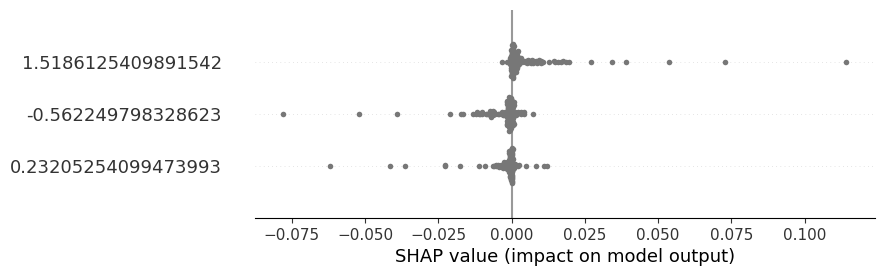

Class 1


c:\Users\DELL PC\Desktop\Machine Learning\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


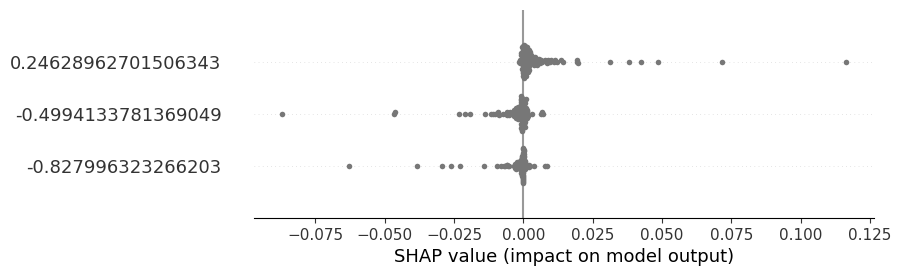

Class 2


c:\Users\DELL PC\Desktop\Machine Learning\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


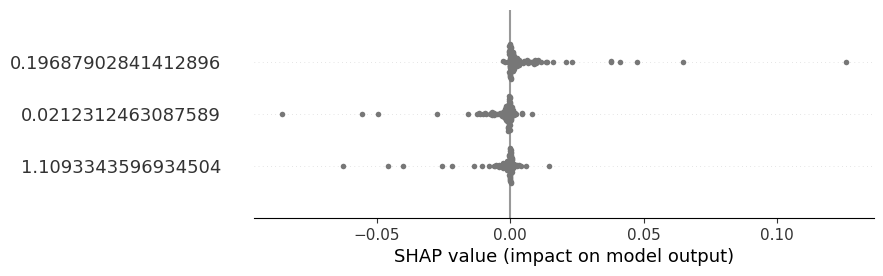

Class 3


c:\Users\DELL PC\Desktop\Machine Learning\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


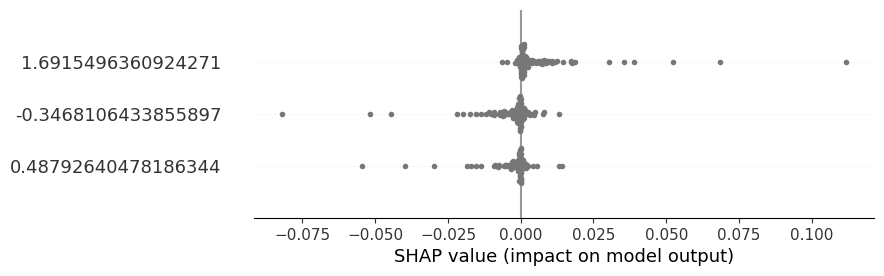

Class 4


c:\Users\DELL PC\Desktop\Machine Learning\venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1437: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


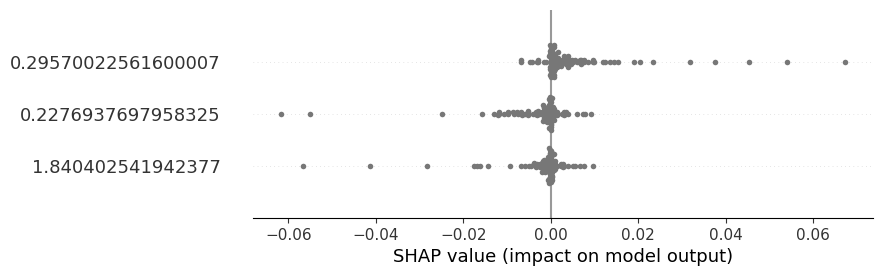

In [35]:
#we are going to do this using SHAP that is SHapley Additive exPlanations.
for i in range(5):
    print(f"Class {i}")
    shap.plots.beeswarm(shap_values[i])

